In [78]:
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from datetime import datetime
from pathlib import Path

In [79]:
alpaca_api_key = "PKJYB527YAQVS4J907RJ"
alpaca_secret_key = "zb5bvTpu8cWaKIgAbDCESouV9MX0qn4RXiQzS5n8"

In [80]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [81]:
# Set the tickers
tickers = ["SPY"]

In [82]:
# Set timeframe to one day ("1Day") for the Alpaca API
timeframe = "1Day"

In [83]:
# Format start and end dates as ISO format for one year period
start = pd.Timestamp("2014-02-07", tz="America/New_York").isoformat()
end = pd.Timestamp("2020-02-07", tz="America/New_York").isoformat()



In [84]:
# Get closing prices for SPY from the last year
df_portfolio_year = alpaca.get_bars(
    tickers,
    timeframe,
    start = start,
    end = end
).df

# Display sample data
df_portfolio_year.head(10)

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,201.0192,201.03,198.59,655489,200.490,225903783,200.656423,SPY
2016-01-05 05:00:00+00:00,201.3600,201.90,200.05,418709,201.405,112719152,201.084280,SPY
2016-01-06 05:00:00+00:00,198.8200,200.06,197.60,548386,198.330,153948196,198.956460,SPY
2016-01-07 05:00:00+00:00,194.0500,197.44,193.59,796451,195.330,216191953,195.345911,SPY
2016-01-08 05:00:00+00:00,191.9230,195.85,191.58,754102,195.190,216105404,193.644537,SPY
2016-01-11 05:00:00+00:00,192.1100,193.41,189.82,701548,193.010,205368067,191.757659,SPY
2016-01-12 05:00:00+00:00,193.6608,194.55,191.14,635749,193.820,175844276,192.902295,SPY
2016-01-13 05:00:00+00:00,188.8300,194.86,188.38,812694,194.450,223632834,191.134590,SPY
2016-01-14 05:00:00+00:00,191.9300,193.26,187.66,824320,189.550,243821116,190.776550,SPY


In [85]:
df_portfolio_year = df_portfolio_year.drop(columns=['symbol'])

In [86]:
df_portfolio_year['shifted_close'] = df_portfolio_year['close'].shift(periods=5)

In [87]:
df_portfolio_year['signal'] = 0
df_portfolio_year

,close,high,low,trade_count,open,volume,vwap,shifted_close,signal
timestamp,,,,,,,,,
2016-01-04 05:00:00+00:00,201.0192,201.0300,198.59,655489,200.490,225903783,200.656423,NaN,0
2016-01-05 05:00:00+00:00,201.3600,201.9000,200.05,418709,201.405,112719152,201.084280,NaN,0
2016-01-06 05:00:00+00:00,198.8200,200.0600,197.60,548386,198.330,153948196,198.956460,NaN,0
2016-01-07 05:00:00+00:00,194.0500,197.4400,193.59,796451,195.330,216191953,195.345911,NaN,0
2016-01-08 05:00:00+00:00,191.9230,195.8500,191.58,754102,195.190,216105404,193.644537,NaN,0
...,...,...,...,...,...,...,...,...,...
2020-02-03 05:00:00+00:00,324.1200,326.1600,323.22,368446,323.350,71170107,324.389725,323.51,0
2020-02-04 05:00:00+00:00,329.0600,330.0100,327.72,312753,328.070,64065469,328.623197,326.88,0
2020-02-05 05:00:00+00:00,332.8400,333.0900,330.67,352029,332.270,67402342,332.020257,326.62,0


In [88]:
def signal_creator(row):
    percent_diff = (row['close'] - row['shifted_close']) / row['shifted_close']
    if percent_diff > 0.03:
        return 1
    elif percent_diff < -0.03:
        return -1
    else:
        return 0


In [89]:
df_portfolio_year['signal'] = df_portfolio_year.apply(signal_creator, axis=1)
df_portfolio_year.dropna(inplace=True)
df_portfolio_year.head(20)

,close,high,low,trade_count,open,volume,vwap,shifted_close,signal
timestamp,,,,,,,,,
2016-01-11 05:00:00+00:00,192.1100,193.4100,189.82,701548,193.01,205368067,191.757659,201.0192,-1
2016-01-12 05:00:00+00:00,193.6608,194.5500,191.14,635749,193.82,175844276,192.902295,201.3600,-1
2016-01-13 05:00:00+00:00,188.8300,194.8600,188.38,812694,194.45,223632834,191.134590,198.8200,-1
2016-01-14 05:00:00+00:00,191.9300,193.2600,187.66,824320,189.55,243821116,190.776550,194.0500,0
2016-01-15 05:00:00+00:00,187.8100,188.7600,185.52,1104776,186.77,333774073,187.694544,191.9230,0
2016-01-19 05:00:00+00:00,188.0600,190.1100,186.20,700807,189.96,207102007,188.299628,192.1100,0
2016-01-20 05:00:00+00:00,185.6500,187.4950,181.02,1102479,185.03,293247287,184.200832,193.6608,-1
2016-01-21 05:00:00+00:00,186.6900,188.8700,184.64,805415,186.21,199821181,186.968758,188.8300,0
2016-01-22 05:00:00+00:00,190.5200,190.7600,188.88,613543,189.78,171389049,189.815621,191.9300,0


In [90]:
df_portfolio_year.drop(columns=['shifted_close'],inplace=True)
df_portfolio_year

,close,high,low,trade_count,open,volume,vwap,signal
timestamp,,,,,,,,
2016-01-11 05:00:00+00:00,192.1100,193.4100,189.82,701548,193.01,205368067,191.757659,-1
2016-01-12 05:00:00+00:00,193.6608,194.5500,191.14,635749,193.82,175844276,192.902295,-1
2016-01-13 05:00:00+00:00,188.8300,194.8600,188.38,812694,194.45,223632834,191.134590,-1
2016-01-14 05:00:00+00:00,191.9300,193.2600,187.66,824320,189.55,243821116,190.776550,0
2016-01-15 05:00:00+00:00,187.8100,188.7600,185.52,1104776,186.77,333774073,187.694544,0
...,...,...,...,...,...,...,...,...
2020-02-03 05:00:00+00:00,324.1200,326.1600,323.22,368446,323.35,71170107,324.389725,0
2020-02-04 05:00:00+00:00,329.0600,330.0100,327.72,312753,328.07,64065469,328.623197,0
2020-02-05 05:00:00+00:00,332.8400,333.0900,330.67,352029,332.27,67402342,332.020257,0


In [91]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
# Replace p, d, q with your chosen values
p = 5
d = 1
q = 0

model = ARIMA(df_portfolio_year['close'], order=(p, d, q))
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(steps=5)

# Display the forecast
print(forecast)


1027    332.240037
1028    332.164758
1029    332.000893
1030    332.013374
1031    332.056622
Name: predicted_mean, dtype: float64


/Users/jangutt/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jangutt/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jangutt/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jangutt/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1032
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2212.790
Date:                Mon, 11 Dec 2023   AIC                           4437.581
Time:                        19:02:30   BIC                           4467.210
Sample:                    01-04-2016   HQIC                          4448.825
                         - 02-07-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0275      0.021     -1.287      0.198      -0.069       0.014
ar.L2         -0.0401      0.022     -1.816      0.069      -0.083       0.003
ar.L3          0.0352      0.021      1.655      0.0

/var/folders/v3/74k5z7qn6s9blqgwvn0v3rbm0000gn/T/ipykernel_94385/3914163700.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  series.index = pd.to_datetime(series.index).to_period('D')


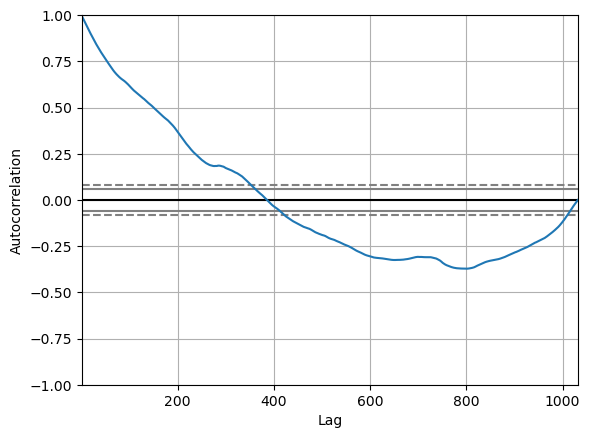

In [92]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

# Fetching data from Alpaca (example for 'SPY')
symbol = "SPY"
start_date = "2014-02-07"
end_date = "2020-02-07"
timeframe = tradeapi.TimeFrame.Day

df = alpaca.get_bars(symbol, timeframe, start_date, end_date).df

# Use 'close' prices for ARIMA
series = df['close']

# Convert the index to a PeriodIndex for daily frequency
series.index = pd.to_datetime(series.index).to_period('D')

# Fit the ARIMA model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

# Summary of the fitted model
print(model_fit.summary())

# Check index type and plot autocorrelation
print("Index type before conversion:", type(series.index))
autocorrelation_plot(series)
pyplot.show()

In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Split the DataFrame into training and testing sets (90% train, 10% test)
train_data, test_data = df_portfolio_year[0:int(len(df_portfolio_year)*0.9)], df_portfolio_year[int(len(df_portfolio_year)*0.9):]

# Prepare the training and testing data (using 'close' prices)
train_arima = train_data['close']
test_arima = test_data['close']

# Initialize history with the training data
history = [x for x in train_arima]
# Prepare a list to store the forecasts
predictions = []

# Loop over the test data
for t in range(len(test_arima)):
    # Fit the ARIMA model
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()

    # Forecast the next value
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)

    # Add the actual observation to history for the next loop
    history.append(test_arima.iloc[t])


In [98]:
# report performance
mse = mean_squared_error(test_arima, predictions)
print('MSE: ' + str(mse))

mae = mean_absolute_error(test_arima, predictions)
print('MAE: ' + str(mae))

rmse = math.sqrt(mse)
print('RMSE: ' + str(rmse))

MSE: 3.974797582050412
MAE: 1.5043959754395586
RMSE: 1.9936894397198406


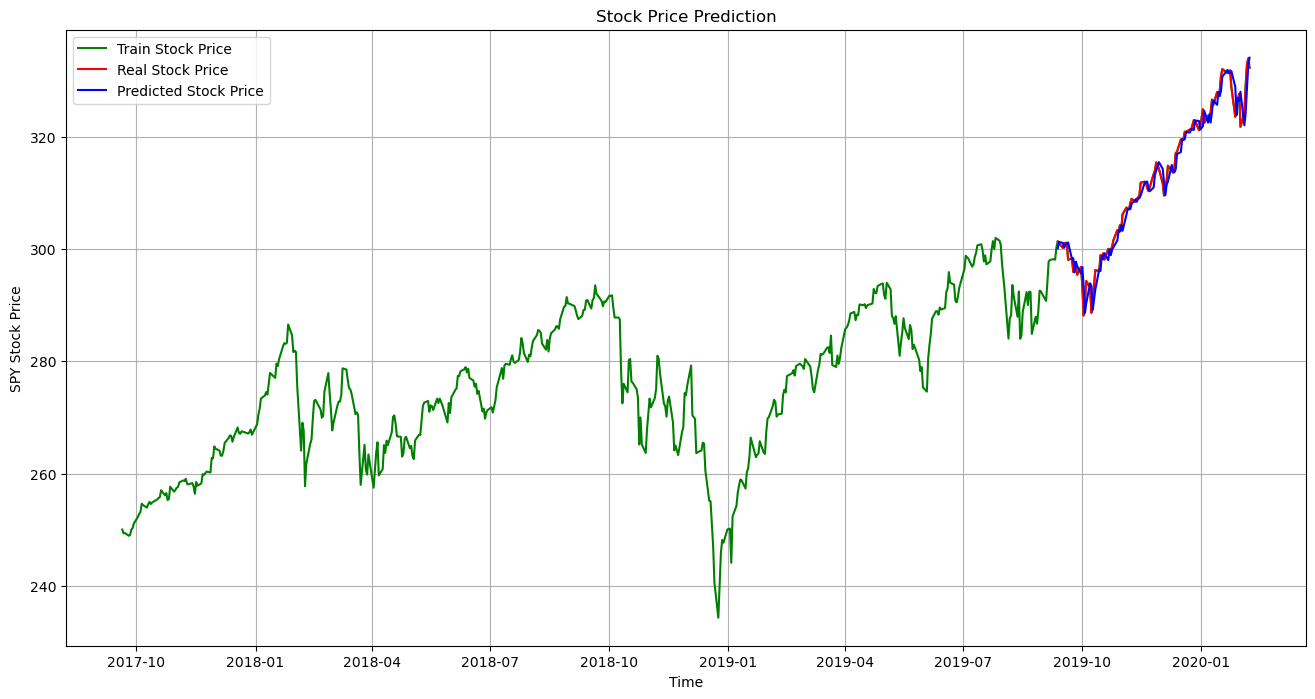

In [105]:
# Plot the predictions
plt.figure(figsize=(16,8))
plt.plot(df_portfolio_year.index[-600:], df_portfolio_year['close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_arima, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

